In [24]:
import tensorflow as tf
import keras
from keras import layers
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [25]:
# Constantes
IS_TO_FIND_BEST_HYPERPARAMS = True
IS_TO_TRAIN = True
IS_TO_REPLICATE = True
BATCH_SIZE = 32
IMG_HEIGHT = 160    
IMG_WIDTH =160

DATASET_TRAIN_PATH = "../cats_and_dogs/train"  # ajustar consoante a localização do dataset
           
DATASET_VAL_PATH = "../cats_and_dogs/validation"  # ajustar consoante a localização do dataset
NUM_CLASSES=2
SEED = None if IS_TO_TRAIN else 12345
MAX_EPOCHS = 50
WEIGHTS_FILENAME = "models/best_binary_model.weights.h5"
HYPERPARAMS_FILENAME = "models/best_binary_model.hyperparams.json"

In [26]:
# ficheiro onde serão guardados os pesos do "melhor modelo" - ajustar o caminho
BEST_MODEL_PATH = "tmp/best_model.weights.h5"

# callback para guardar o melhor modelo
BEST_MODEL_CHECKPOINT = keras.callbacks.ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# callback para parar o treino caso não se verifiquem melhorias na loss
EARLY_STOPPING = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

In [27]:

DATASET_PATH = "./cats_and_dogs"
SEED = 7654321  # semente para o split validação/teste com melhor distribuição

train_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH + '/train',
    labels='inferred',
    label_mode='binary',
    seed=SEED,
    batch_size=BATCH_SIZE
)
val_ds, test_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH + '/validation',
    labels='inferred',
    label_mode='binary',
    validation_split=0.5,
    subset="both",
    seed=SEED,
    batch_size=BATCH_SIZE
)

# as labels foram inferidas a partir dos nomes dos diretórios
labels = train_ds.class_names
print("Encontradas as classes: ", labels)

# carregar os datasets em memória - uma vez carregados, a ordem dos batches já não muda
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Using 500 files for training.
Using 500 files for validation.
Encontradas as classes:  ['cats', 'dogs']


In [35]:
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=SEED)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15)
])
# catOrDog_model = keras.Sequential([
#     layers.Input(shape=(160, 160, 3)),  # Input shape
#     data_augmentation,
#     layers.Conv2D(8, 5, padding='same', activation='relu', kernel_initializer=initializer),
#     layers.MaxPooling2D(),
#     layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
#     layers.MaxPooling2D(pool_size=(5, 5)),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu', kernel_initializer=initializer),  # Adjusted to 256
#     layers.Dense(1, activation="sigmoid")
# ])

catOrDog_model = keras.Sequential([
layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
layers.Conv2D(16, 5, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu'),
layers.MaxPooling2D(pool_size=(5, 5)),
layers.GlobalAveragePooling2D(),
layers.Dense(128, activation='relu'),
layers.Dense(1, activation="softmax")])
# definição do algoritmo de otimização e da função de perda (loss)
catOrDog_model.compile(
                     loss="binary_crossentropy",
                     optimizer=keras.optimizers.Adam(learning_rate=0.01),
                     metrics=['accuracy'])

# sumário do modelo
catOrDog_model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 160, 160, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 80, 80, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,801 (128.13 KB)

 Trainable params: 32,801 (128.13 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = catOrDog_model.fit(
    train_ds,
    epochs=MAX_EPOCHS,
    validation_data=val_ds,
    callbacks=[BEST_MODEL_CHECKPOINT, EARLY_STOPPING]
)

Epoch 1/50


c:\Users\GONCA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.4940 - loss: 8.4102 - val_accuracy: 0.4980 - val_loss: 0.6598
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.4940 - loss: 0.6812 - val_accuracy: 0.4980 - val_loss: 0.6672
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.4940 - loss: 0.6682 - val_accuracy: 0.4980 - val_loss: 0.6444
Epoch 4/50
53/63 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.4931 - loss: 0.6672

KeyboardInterrupt: 

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step


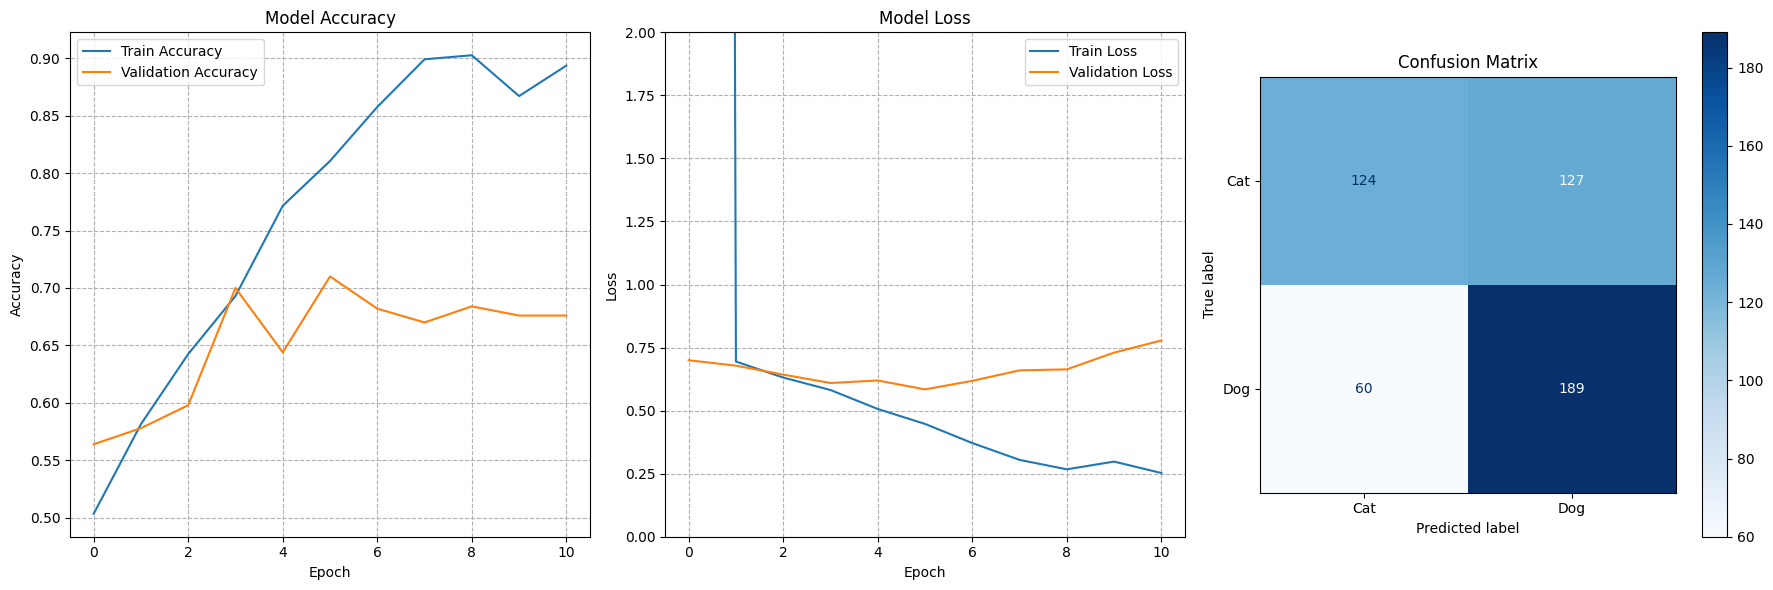

In [ ]:

y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

# Make predictions
output_pred = catOrDog_model.predict(val_ds)
y_pred = (output_pred > 0.5).astype(int).flatten()  # Convert sigmoid output to 0 or 1

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, linestyle="--")

# Plot Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_ylim(0, 2.0)
axes[1].legend()
axes[1].grid(True, linestyle="--")

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(ax=axes[2], cmap=plt.cm.Blues)
axes[2].set_title('Confusion Matrix')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:


# from tensorflow import keras
# from tensorflow.keras import layers
# from scikeras.wrappers import KerasClassifier  # Updated import
# from sklearn.model_selection import GridSearchCV
# import numpy as np

# # Define a function to create the model
# def create_model(learning_rate=0.001, dropout_rate=0.25, dense_units=1012):
#     initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=SEED)

#     model = keras.Sequential([
#         layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#         data_augmentation,
#         layers.Conv2D(16, 5, padding='same', activation='relu', kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D(),
#         layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D(),
#         layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D(),
#         layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D(),
#         layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D(pool_size=(7, 7)),
#         layers.Dropout(dropout_rate),
#         layers.Flatten(),
#         layers.Dense(dense_units, activation='relu', kernel_initializer=initializer),
#         layers.Dropout(0.5),
#         layers.Dense(1, activation="sigmoid")
#     ])

#     model.compile(
#         loss="binary_crossentropy",
#         optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
#         metrics=['accuracy']
#     )
#     return model

# # Wrap the model in KerasClassifier
# model = KerasClassifier(model=create_model, verbose=1)

# # Define the hyperparameter grid
# param_grid = {
#     'learning_rate': [0.001, 0.0001],
#     'dropout_rate': [0.25, 0.5],
#     'dense_units': [512, 1012],
#     'batch_size': [32, 64],
#     'epochs': [20, 30]
# }

# # Perform grid search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
# grid_result = grid.fit(train_ds, val_ds)  # Replace with your training data

# # Print the best results
# print(f"Best Accuracy: {grid_result.best_score_} using {grid_result.best_params_}")

TypeError: Input should have at least 1 dimension i.e. satisfy `len(x.shape) > 0`, got scalar `array(<CacheDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
      dtype=object)` instead.